API Key: SweUmsit7q4bITjAHGJbHRlWs
API Secret Key: dDpm4VZc48MMUgp5s8JrpdozM1YrKO3PBUKKMeEXTTQAJGCeUx
Bearer Token: AAAAAAAAAAAAAAAAAAAAAJmjLAEAAAAAzl9HA9NDExmrahuPmTmxF8XZSEQ%3D2hsAYb5058B25ue4B5XW8NErOtQAlzcp6HQzjTEF7a4t2hY9Mz


# TwitterAPI Setup

In [10]:
import os #collection of operating system interfaces
import tweepy as tw #library for TwitterAPI
import pandas as pd #data analysis package
from fastai.text import *
from pandas import DataFrame


In [2]:
#global to store each key
consumer_key= 'SweUmsit7q4bITjAHGJbHRlWs'
consumer_secret= 'dDpm4VZc48MMUgp5s8JrpdozM1YrKO3PBUKKMeEXTTQAJGCeUx'
access_token= '1273017906281021440-UswJnLXQblHPaFbcH6JqO7UU0f2amL'
access_token_secret= '3QBeKVF1cZnApZKfEF3TGA11KxFpi3MykCLMa9X7ZibrW'


In [3]:
auth = tw.OAuthHandler(consumer_key, consumer_secret) #login info for twitter
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True) #creates instance of TwitterAPI


# Build Dataset

In [4]:
userID = "MagicJohnson" #set Twitter user ID
user = api.get_user(userID) #returns the user information
data = []

#get every tweet from Magic Johnson's account
raw_tweets = tw.Cursor(api.user_timeline, screen_name=userID, tweet_mode = "extended").items()

#creates a list of tweets
for tweet in raw_tweets:
    data.append(tweet.full_text)
    

In [18]:
df = DataFrame(data,columns=['tweets']) #create df from list

# Data Processing

In [19]:
#Here, we split the data (10%) and tokenize with a bunch size of 32. This is a micro-bunch that 
#can lead to faster processing of the tweets
df = (TextList.from_df(df, cols='tweets')
                .split_by_rand_pct(0.1)
               .label_for_lm()  
                .databunch(bs=48))

df.show_batch()

idx,text
0,xxmaj sending prayers to the entire xxmaj westphal family ! xxbos xxmaj sending my thoughts and prayers to the family of xxup nba xxmaj champion and xxmaj hall of xxmaj famer xxup xxunk xxmaj jones . xxup rip in my friend 🙏 🏾 xxbos xxmaj what a xxunk written article on my sister @lakers owner @jeaniebuss in the xxup xxunk by xxunk 👏 xxunk : / / t.co / xxunk
1,"/ xxunk xxbos xxmaj let ’s continue to educate our communities and loved ones . xxmaj xxunk is key and those living with xxup hiv can live long and healthy lives . xxmaj there is still a lot of work to be done and i will continue to unite in the fight ! xxbos xxmaj while we continue to work xxunk a xxunk , it ’s important to continue to"
2,"young women and minorities throughout this country and the world ! xxbos xxmaj cookie and i are so excited for xxmaj vice xxmaj president xxmaj elect @kamalaharris . xxmaj we have been major supporters of her throughout her political career , hosting fundraising events and xxunk her into our home . xxmaj vice xxmaj president xxmaj elect xxmaj harris , has not only xxunk the xxunk in her career ..."
3,"- xxmaj thomas ! # xxunk https : / / t.co / xxunk xxbos xxmaj shoutout to xxmaj max xxmaj muncy for xxunk in 2 runs and 2 xxunk ! xxbos xxup rt @dodgers : # xxunk ! \n \n xxup final : # xxmaj dodgers 8 , xxmaj rays 3 https : / / t.co / xxunk xxbos xxmaj cody xxmaj bellinger hit a xxup hr and took"
4,"no xxunk , even though i xxunk in the xxunk . xxmaj xxunk i took care of it so now i can receive my ballot ! xxbos xxmaj dodger xxmaj nation , it was a total team effort in tonight ’s 12 - 3 victory over the xxmaj padres . i want to congratulate our xxmaj men in xxmaj blue as we move on to the xxup nlcs against the"


In [21]:
df.vocab.itos[:20] #20 most commonly used dictionary items

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '/',
 'the',
 ',',
 '.',
 'and',
 '!']

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


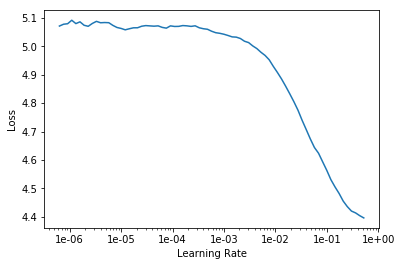

In [25]:
learn = language_model_learner(df,arch = AWD_LSTM, pretrained = True, drop_mult=0.3)
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [26]:
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.801915,4.216535,0.288170,04:03
1,4.146416,3.267071,0.380432,04:25
2,3.572851,2.928928,0.402455,04:39
3,3.139931,2.809767,0.408557,04:35
4,2.818824,2.764635,0.412798,04:47
5,2.582640,2.753370,0.415848,05:17
6,2.394820,2.750673,0.417113,04:45
7,2.249310,2.751622,0.416220,04:45
8,2.152661,2.753594,0.416667,05:00
9,2.100501,2.750956,0.416667,05:00


In [27]:
learn.save('tweet_head')
learn.load('tweet_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (2888 items)
x: LMTextList
xxbos a career high xxunk points for xxmaj steph xxmaj curry ! xxup still xxunk he ’s the greatest xxunk we ’ve ever seen and a xxup mvp candidate along with lebron , xxup ad , xxup kd , xxmaj kyrie , xxmaj luka xxmaj doncic , xxmaj kawhi , and xxmaj giannis !,xxbos xxup rip to xxup nba xxmaj hall of xxmaj famer xxmaj paul xxmaj westphal . xxmaj sending prayers to the entire xxmaj westphal family !,xxbos xxmaj sending my thoughts and prayers to the family of xxup nba xxmaj champion and xxmaj hall of xxmaj famer xxup xxunk xxmaj jones . xxup rip in my friend 🙏 🏾,xxbos xxmaj what a xxunk written article on my sister @lakers owner @jeaniebuss in the xxup xxunk by xxunk 👏 xxunk : / / t.co / xxunk,xxbos xxmaj have a magical xxunk and xxmaj happy xxmaj new xxmaj year from the xxmaj johnson family ! ! ! https : / / t.co / xxunk
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (320 items)
x: LMTextList
xxbos xxmaj

In [28]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.000010,2.754928,0.417113,03:56
1,2.004954,2.755809,0.417857,04:19
2,2.003343,2.751044,0.415625,04:27
3,2.000515,2.753527,0.416443,04:27
4,1.985585,2.758797,0.415997,06:36


In [29]:
learn.save('tweet_fine_tuned')
learn.load('tweet_fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (2888 items)
x: LMTextList
xxbos a career high xxunk points for xxmaj steph xxmaj curry ! xxup still xxunk he ’s the greatest xxunk we ’ve ever seen and a xxup mvp candidate along with lebron , xxup ad , xxup kd , xxmaj kyrie , xxmaj luka xxmaj doncic , xxmaj kawhi , and xxmaj giannis !,xxbos xxup rip to xxup nba xxmaj hall of xxmaj famer xxmaj paul xxmaj westphal . xxmaj sending prayers to the entire xxmaj westphal family !,xxbos xxmaj sending my thoughts and prayers to the family of xxup nba xxmaj champion and xxmaj hall of xxmaj famer xxup xxunk xxmaj jones . xxup rip in my friend 🙏 🏾,xxbos xxmaj what a xxunk written article on my sister @lakers owner @jeaniebuss in the xxup xxunk by xxunk 👏 xxunk : / / t.co / xxunk,xxbos xxmaj have a magical xxunk and xxmaj happy xxmaj new xxmaj year from the xxmaj johnson family ! ! ! https : / / t.co / xxunk
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (320 items)
x: LMTextList
xxbos xxmaj

In [61]:
TEXT = "Magic"
N_WORDS = 20
N_SENTENCES = 1



In [60]:
print("\n".join(learn.predict(TEXT, N_WORDS) for _ in range(N_SENTENCES)))

My cock was incredible for me , and i enjoyed speaking to my amazing wife at my home . i ’m trying
